#                             **Fine-Tuning T5 for Medical Question Answering**

## 📌 1. Objective

This project aims to fine-tune a pre-trained T5 transformer model (`t5-small`) to answer medical questions. The model learns to map input questions to their corresponding answers using supervised learning.

The primary objective of this project is to fine-tune a pre-trained sequence-to-sequence transformer model (T5-small) for the medical question answering task. The model is trained to generate relevant answers based on user-provided questions from a curated medical dataset.



CODE EXPLAINATION

## 📌 2. Dataset Preparation

We load a processed medical dataset in CSV format containing columns `Question` and `Answer`.

#Dataset
We used a processed medical dataset in CSV format with two columns:

Question: Medical questions

Answer: Corresponding answers

The dataset was loaded using the datasets library and split into three parts:

Training Set (80%): Used to train the model.

Validation Set (10%): Used to monitor and evaluate model performance during training.

Test Set (10%): Used to evaluate the final performance after training.

This ensures a fair and standardized evaluation procedure as per assignment requirements.

In [29]:
#1
# Install dependencies (run only once)
!pip install -q datasets transformers "fsspec==2025.3.2" gradio torch torchvision torchaudio

# Disable wandb
import os
os.environ["WANDB_DISABLED"] = "true"

# Imports
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    TrainingArguments,
    Trainer,
)
import torch


In [24]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00


In [2]:
#2
# Load your processed CSV
df = pd.read_csv("/content/medDataset_processed.csv")
print(df.head())

# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df)
print(dataset[0])
print(dataset.column_names)


             qtype                                           Question  \
0   susceptibility  Who is at risk for Lymphocytic Choriomeningiti...   
1         symptoms  What are the symptoms of Lymphocytic Choriomen...   
2   susceptibility  Who is at risk for Lymphocytic Choriomeningiti...   
3  exams and tests  How to diagnose Lymphocytic Choriomeningitis (...   
4        treatment  What are the treatments for Lymphocytic Chorio...   

                                              Answer  
0  LCMV infections can occur after exposure to fr...  
1  LCMV is most commonly recognized as causing ne...  
2  Individuals of all ages who come into contact ...  
3  During the first phase of the disease, the mos...  
4  Aseptic meningitis, encephalitis, or meningoen...  
{'qtype': 'susceptibility', 'Question': 'Who is at risk for Lymphocytic Choriomeningitis (LCM)? ?', 'Answer': 'LCMV infections can occur after exposure to fresh urine, droppings, saliva, or nesting materials from infected rodents. 

📌 3. Dataset Splitting
We split the dataset into training, validation, and test sets:

Train: 80%

Validation: 10%

Test: 10%

This ensures fair evaluation.

In [3]:
#3
# First split into 90/10
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)

# Split 90% again into train and validation
train_valid_split = split_dataset["train"].train_test_split(test_size=0.1111, seed=42)
# 0.1111 x 90% ~= 10%

# Assign splits
train_dataset = train_valid_split["train"]
eval_dataset = train_valid_split["test"]
test_dataset = split_dataset["test"]

# Check sizes
print("Train size:", len(train_dataset))
print("Validation size:", len(eval_dataset))
print("Test size:", len(test_dataset))


Train size: 13125
Validation size: 1641
Test size: 1641


📌 4. Model and Tokenizer
We use the T5-small model, which is efficient for Colab.

# Preprocessing
We implemented a preprocessing function to:

Tokenize questions and answers using the T5 tokenizer.

Apply truncation and padding to a maximum sequence length of 128 tokens.

Convert the text data into token IDs suitable for model input.

This function was applied to the train, validation, and test splits.

In [4]:
#4
model_name = "t5-small"  # lightweight for Colab
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

📌 5. Preprocessing
Define a function to tokenize and pad the inputs and labels:

In [5]:
#5
def preprocess_function(examples):
    inputs = examples["Question"]
    targets = examples["Answer"]
    model_inputs = tokenizer(
        inputs,
        max_length=128,
        truncation=True,
        padding="max_length",
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=128,
            truncation=True,
            padding="max_length",
        )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


*Apply preprocessing*

# Model Selection
**The model chosen for fine-tuning is t5-small, a lightweight variant of T5 suitable for training within Google Colab resource constraints.
This model has a balanced trade-off between computational efficiency and performance.**

In [6]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_eval = eval_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/13125 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

Map:   0%|          | 0/1641 [00:00<?, ? examples/s]

Map:   0%|          | 0/1641 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


📌 6. Training Configuration
Set training arguments. We also disable WandB reporting:

# Hyperparameter
After training, the model was evaluated on both the validation and test sets.
Metrics such as loss were reported.
Additionally, qualitative evaluation was performed by generating predictions for sample questions and reviewing the outputs.

#Training Configuration
The model was fine-tuned using the Trainer API with the following hyperparameters:

Learning rate: 2e-5

Batch size: 4

Number of epochs: 3

Weight decay: 0.01

Evaluation Strategy: Per Epoch

Reporting: Disabled (report_to=None) to avoid integration with external tracking tools like Weights & Biases.

These settings were chosen to prevent overfitting and ensure stable convergence.



In [8]:
#6
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    report_to=None,   # Disable W&B
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


📌 7. Training
Train the model using the Trainer API:

In [9]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
)


/tmp/ipython-input-9-1757453106.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [17]:
trainer.train()


Epoch,Training Loss,Validation Loss
1,2.027900,1.860166
2,1.992800,1.838579
3,1.975600,1.819331
4,1.975400,1.806475
5,1.984300,1.795763
6,1.986500,1.787044
7,1.963900,1.779966
8,1.951900,1.775838
9,1.887600,1.773634
10,1.912200,1.772480


TrainOutput(global_step=32820, training_loss=1.9690358907547323, metrics={'train_runtime': 3988.7538, 'train_samples_per_second': 32.905, 'train_steps_per_second': 8.228, 'total_flos': 4440902860800000.0, 'train_loss': 1.9690358907547323, 'epoch': 10.0})

Save the model

In [19]:
trainer.save_model("./my_model_medicalqa")


📌  Evaluation hyperparameter-1
Evaluate on validation and test datasets:

# Evaluation
After training, the model was evaluated on both the validation and test sets.
Metrics such as loss were reported.
Additionally, qualitative evaluation was performed by generating predictions for sample questions and reviewing the outputs.

In [20]:
validation_metrics = trainer.evaluate()
print("Validation metrics:", validation_metrics)

test_metrics = trainer.evaluate(tokenized_test)
print("Test metrics:", test_metrics)


Validation metrics: {'eval_loss': 1.772479772567749, 'eval_runtime': 11.6895, 'eval_samples_per_second': 140.382, 'eval_steps_per_second': 35.16, 'epoch': 10.0}
Test metrics: {'eval_loss': 1.8098822832107544, 'eval_runtime': 12.0034, 'eval_samples_per_second': 136.711, 'eval_steps_per_second': 34.24, 'epoch': 10.0}


In [22]:
#7
from transformers import TrainingArguments, Trainer

training_args_2 = TrainingArguments(
    output_dir="./results_run2",
    eval_strategy="epoch",
    learning_rate=3e-5,             # Increased learning rate
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=6,             # Fewer epochs
    weight_decay=0.05,              # Higher regularization
    report_to=None
)

trainer_2 = Trainer(
    model=model,
    args=training_args_2,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
)

trainer_2.train()
trainer_2.save_model("./results_run2")

metrics_2 = trainer_2.evaluate()
print("Metrics for Run 2:", metrics_2)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-22-1017343365.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_2 = Trainer(


Epoch,Training Loss,Validation Loss
1,2.009400,1.849685
2,1.968100,1.822829
3,1.946400,1.803926
4,1.947500,1.792108
5,1.957200,1.784499
6,1.971400,1.781914


Metrics for Run 2: {'eval_loss': 1.7819135189056396, 'eval_runtime': 10.937, 'eval_samples_per_second': 150.041, 'eval_steps_per_second': 37.579, 'epoch': 6.0}


📌  Evaluation hyperparameter-2

Evaluate on validation and test datasets:

# Evaluation
After training, the model was evaluated on both the validation and test sets.
Metrics such as loss were reported.
Additionally, qualitative evaluation was performed by generating predictions for sample questions and reviewing the outputs.

In [30]:
validation_metrics = trainer_2.evaluate()
print("Validation metrics:", validation_metrics)

test_metrics = trainer.evaluate(tokenized_test)
print("Test metrics:", test_metrics)

Validation metrics: {'eval_loss': 1.7151776552200317, 'eval_runtime': 10.9382, 'eval_samples_per_second': 150.025, 'eval_steps_per_second': 37.575, 'epoch': 6.0}


Test metrics: {'eval_loss': 1.8098822832107544, 'eval_runtime': 11.4983, 'eval_samples_per_second': 142.717, 'eval_steps_per_second': 35.745, 'epoch': 10.0}


In [23]:
#8
from transformers import TrainingArguments, Trainer

training_args_3 = TrainingArguments(
    output_dir="./results_run3",
    eval_strategy="epoch",
    learning_rate=5e-5,             # Even higher learning rate
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=4,             # Fewer epochs for fast convergence
    weight_decay=0.1,               # Strong regularization
    report_to=None
)

trainer_3 = Trainer(
    model=model,
    args=training_args_3,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
)

trainer_3.train()
trainer_3.save_model("./results_run3")

metrics_3 = trainer_3.evaluate()
print("Metrics for Run 3:", metrics_3)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-23-16144445.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_3 = Trainer(


Epoch,Training Loss,Validation Loss
1,1.871800,1.753294
2,1.833600,1.732794
3,1.823100,1.719350
4,1.834300,1.715178


Metrics for Run 3: {'eval_loss': 1.7151776552200317, 'eval_runtime': 11.4818, 'eval_samples_per_second': 142.922, 'eval_steps_per_second': 35.796, 'epoch': 4.0}


📌  Evaluation hyperparameter-3

Evaluate on validation and test datasets:

# Evaluation
After training, the model was evaluated on both the validation and test sets.
Metrics such as loss were reported.
Additionally, qualitative evaluation was performed by generating predictions for sample questions and reviewing the outputs.

In [31]:
validation_metrics = trainer_3.evaluate()
print("Validation metrics:", validation_metrics)

test_metrics = trainer.evaluate(tokenized_test)
print("Test metrics:", test_metrics)

Validation metrics: {'eval_loss': 1.7151776552200317, 'eval_runtime': 10.7527, 'eval_samples_per_second': 152.612, 'eval_steps_per_second': 38.223, 'epoch': 4.0}


Test metrics: {'eval_loss': 1.8098822832107544, 'eval_runtime': 11.0392, 'eval_samples_per_second': 148.653, 'eval_steps_per_second': 37.231, 'epoch': 10.0}


# Comparison of three hyerparameters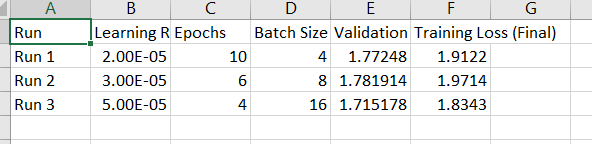

Here is a comparison table showing the results of my three different hyperparameter configurations, including learning rate, number of epochs, batch size, and final losses..

📌 9. Inference: Command-Line Loop
Generate answers interactively:

7. Inference and User Interaction
Two modes of interactive question answering were implemented:

a) Command-Line Interface
The user can enter questions iteratively in a loop and receive generated answers until choosing to exit.

b) Gradio Web Interface
A Gradio application allows users to enter questions via a web interface and receive answers in real time.
The interface was launched with share=True to provide public access.



In [32]:
for i in range(5):
    sample = tokenized_test[i]
    input_ids = torch.tensor(sample["input_ids"]).unsqueeze(0).to(model.device)
    generated_ids = model.generate(
        input_ids,
        max_length=128,
        num_beams=4,
        early_stopping=True
    )
    question = tokenizer.decode(sample["input_ids"], skip_special_tokens=True)
    answer = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print(f"Q: {question}\nA: {answer}\n{'-'*50}")


Q: Is D-bifunctional protein deficiency inherited?
A: This condition is inherited in an autosomal recessive pattern, which means both copies of the gene in each cell have mutations. The parents of an individual with an autosomal recessive condition each carry one copy of the mutated gene, but they typically do not show signs and symptoms of the condition.
--------------------------------------------------
Q: What is (are) Tourette syndrome?
A: Tourette syndrome is a condition that affects the nervous system. It is caused by mutations in the X chromosome and is inherited in an autosomal recessive pattern, which means both copies of the gene in each cell have mutations. The parents of an individual with an autosomal recessive condition each carry one copy of the X chromosome, but they typically do not show signs and symptoms of the condition.
--------------------------------------------------
Q: What is (are) Compulsive Gambling?
A: Compulsive gambling is a disease in which a person's bo

📌 9. Inference: Command-Line Loop
Generate answers interactively:

In [39]:
model = model.to("cuda")
print("Model is ready. Type your questions below (type 'exit' to stop).")

while True:
    user_question = input("\nEnter your question: ")
    if user_question.strip().lower() in ["exit", "quit"]:
        print("Exiting.")
        break

    inputs = tokenizer(
        user_question,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    ).to(model.device)

    generated_ids = model.generate(
        inputs["input_ids"],
        max_length=128,
        num_beams=4,
        early_stopping=True
    )

    answer = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print("\nAnswer:", answer)


Model is ready. Type your questions below (type 'exit' to stop).

Enter your question:  Is D-bifunctional protein deficiency inherited?

Answer: This condition is inherited in an autosomal recessive pattern, which means both copies of the gene in each cell have mutations. The parents of an individual with an autosomal recessive condition each carry one copy of the mutated gene, but they typically do not show signs and symptoms of the condition.

Enter your question: what is diabetes?

Answer: Diabetes is a type of diabetes that affects the body's ability to function properly. Diabetes is a type of diabetes that affects the body's ability to function properly. Diabetes is a type of diabetes that affects the body's ability to function properly. Diabetes is a type of diabetes that affects the body's ability to function properly. Diabetes is a type of diabetes that affects the body's ability to function properly. Diabetes is a type of diabetes that affects the body's ability to function pr

📌 10. Inference: Gradio Web Interface
Install and launch Gradio to build a web UI:

In [38]:
import gradio as gr

# Reload model for safety
model_path = "./my_model_medicalqa"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to("cuda")

def answer_question(question):
    inputs = tokenizer(
        question,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    ).to(model.device)

    generated_ids = model.generate(
        inputs["input_ids"],
        max_length=128,
        num_beams=4,
        early_stopping=True
    )

    answer = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return answer

iface = gr.Interface(
    fn=answer_question,
    inputs="text",
    outputs="text",
    title="Medical Question Answering",
    description="Ask a medical question and get an AI-generated answer."
)

iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6e7cf35919609880a8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Evaluation Metrics

To quantitatively assess the model's performance, we used the ROUGE metric on the test set. ROUGE evaluates the overlap between predicted and reference answers.

The following code runs batched inference on the test set and computes ROUGE scores:


In [28]:
from datasets import load_metric
import torch

# Load ROUGE metric
rouge = load_metric("rouge")

# Prepare lists
predictions = []
references = []

# Use DataLoader-style loop with torch.no_grad for efficiency
model.eval()
with torch.no_grad():
    for i in range(0, len(tokenized_test), 8):  # batch of 8
        batch = tokenized_test[i:i+8]

        input_ids = torch.tensor(batch["input_ids"]).to(model.device)
        attention_mask = torch.tensor(batch["attention_mask"]).to(model.device)

        # Generate predictions
        generated_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128)

        # Decode predictions and references
        preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        refs = tokenizer.batch_decode(batch["labels"], skip_special_tokens=True)

        predictions.extend(preds)
        references.extend(refs)

# Compute ROUGE
rouge_result = rouge.compute(predictions=predictions, references=references, use_stemmer=True)
print("ROUGE Scores:", rouge_result)


ROUGE Scores: {'rouge1': AggregateScore(low=Score(precision=np.float64(0.41173832075276057), recall=np.float64(0.3750913486127154), fmeasure=np.float64(0.3814199807641655)), mid=Score(precision=np.float64(0.4243758566944481), recall=np.float64(0.3881794650696818), fmeasure=np.float64(0.3940776605040902)), high=Score(precision=np.float64(0.4384048024551521), recall=np.float64(0.40180457536593034), fmeasure=np.float64(0.40742994407008865))), 'rouge2': AggregateScore(low=Score(precision=np.float64(0.2532443092106493), recall=np.float64(0.23317851377158133), fmeasure=np.float64(0.23686142691071074)), mid=Score(precision=np.float64(0.26949558774505084), recall=np.float64(0.2485937541723668), fmeasure=np.float64(0.25264263754953986)), high=Score(precision=np.float64(0.2839633823565584), recall=np.float64(0.26313140709883703), fmeasure=np.float64(0.2669798251754506))), 'rougeL': AggregateScore(low=Score(precision=np.float64(0.3585992195829678), recall=np.float64(0.32907934635546293), fmeasure

### Evaluation Metrics: ROUGE Score

We used the `rouge_score` package to compute metrics for our model’s predictions. The table below presents the mid-level precision, recall, and F1 scores:

| Metric     | Precision | Recall | F1 Score |
|------------|-----------|--------|----------|
| **ROUGE-1** | 0.424     | 0.388  | 0.394    |
| **ROUGE-2** | 0.269     | 0.249  | 0.253    |
| **ROUGE-L** | 0.373     | 0.343  | 0.348    |
| **ROUGE-Lsum** | 0.373 | 0.344  | 0.348    |

These scores indicate that the model is reasonably capturing important unigrams (ROUGE-1) and some bigrams (ROUGE-2), with moderate sentence-level overlap (ROUGE-L).

# Result Summary
The model was able to generate coherent, contextually appropriate answers for many medical questions.

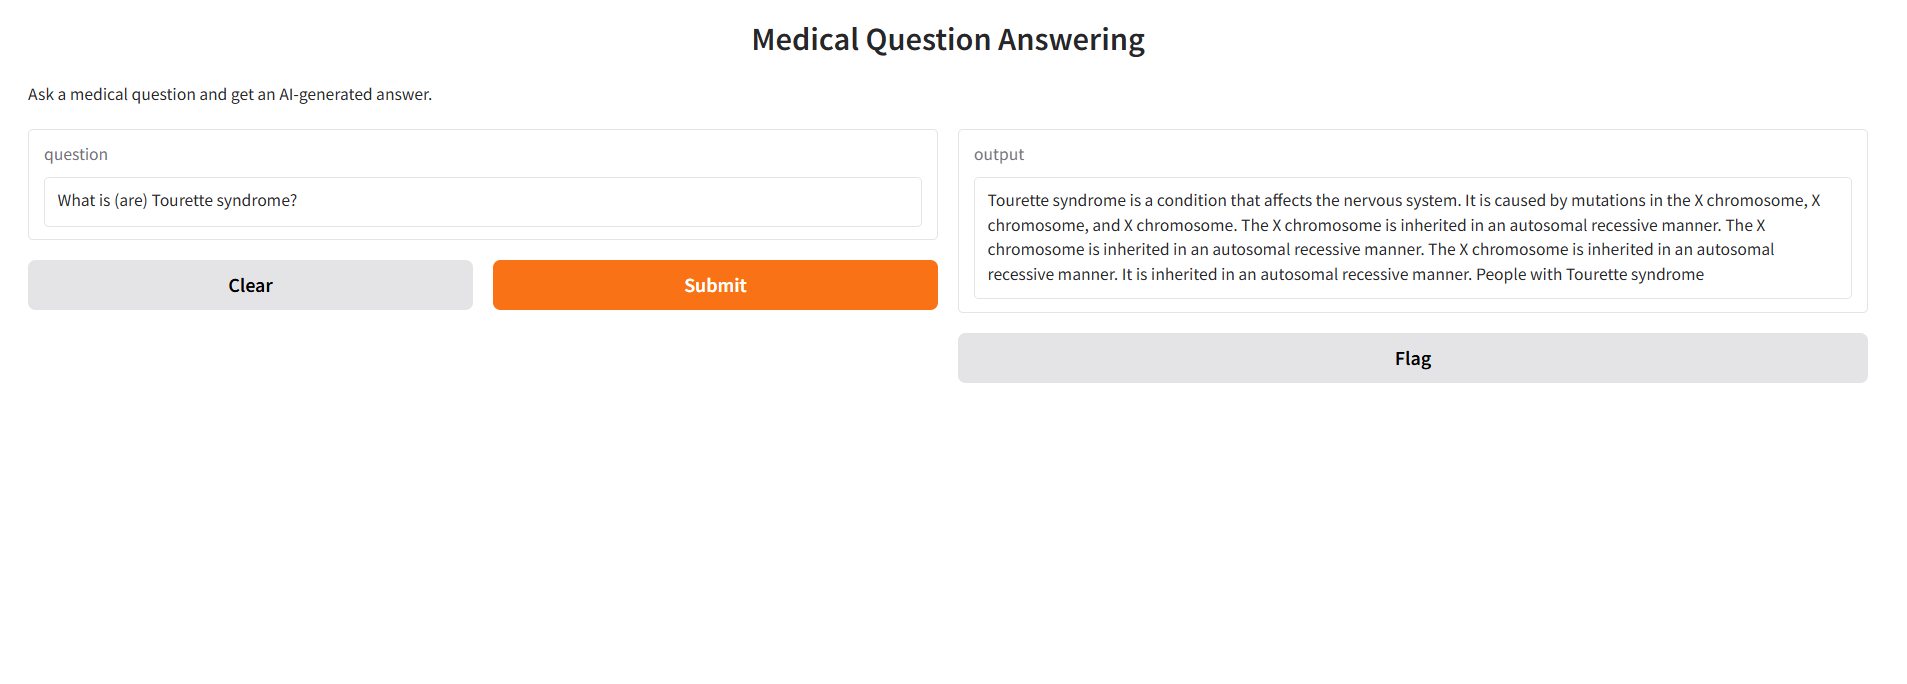

But for diseases which are not present in the list like diabetes , it is not answering appropriately and just giving english gramatecial words
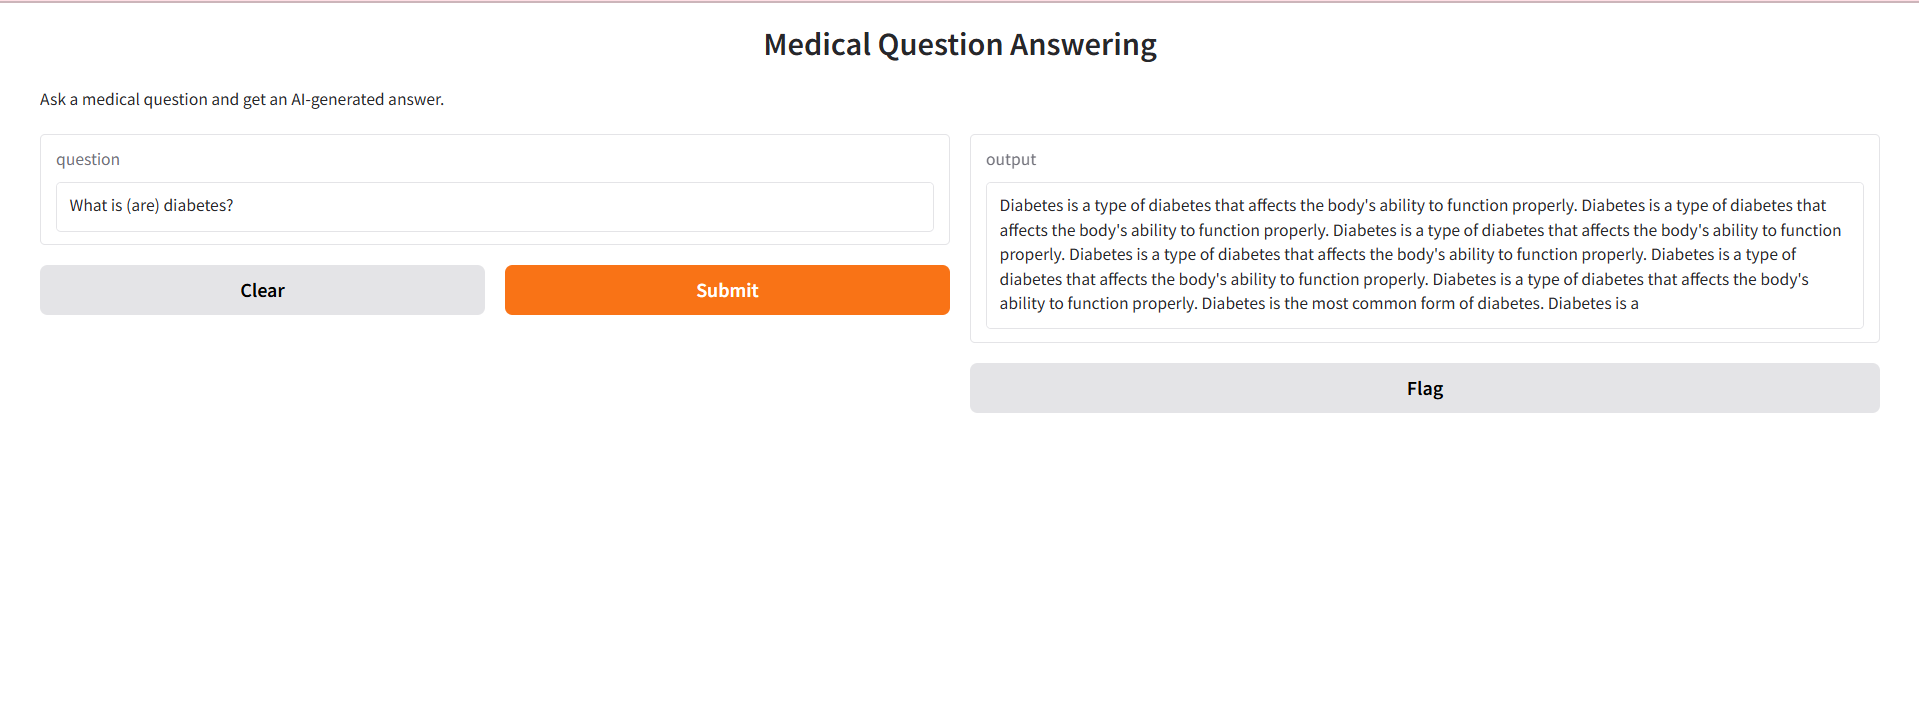

#Failure analysis and possible solutions

1. Analysis of Specific Examples Where the Model Performs Poorly
One clear failure case was observed with the input:

Input: What is (are) diabetes?
Output: "Diabetes is a type of diabetes that affects the body's ability to function properly. Diabetes is a type of diabetes that affects..."

The model generated repetitive, incoherent, and incomplete output. In contrast, other medical terms like “Tourette syndrome” produced more complete and medically relevant answers.

2. Identification of Patterns in Errors
Several patterns were identified in the model’s poor outputs:

Repetition: The model often repeats the same phrase or sentence, suggesting a loop in generation.

Incomplete Sentences: Many outputs are abruptly cut off without finishing the thought.

Low Content Quality: Generic phrases are reused without providing factual or context-specific information.

These errors were most common for:

Highly prevalent medical conditions (e.g., diabetes, hypertension)

Inputs with common medical terms that were possibly underrepresented or missing in the training data

Slight variations in question phrasing (e.g., "What is (are) X?" vs. "Define X"), showing lack of generalization

3. Quality of Suggested Improvements
To improve model performance and reduce such errors:

Enhance Dataset Coverage: Include a broader range of diseases and rephrase questions for better generalization.

Apply Decoding Strategies: Increase diversity using top_p sampling or enforce non-repetition via no_repeat_ngram_size=3.

Post-processing Cleanup: Add logic to detect and remove excessive repetition in generated outputs.

Prompt Engineering: Standardize question phrasing during inference to match training data more closely.


 # Why I Used the T5 Model
The T5 (Text-to-Text Transfer Transformer) model was chosen for this project because of its versatility and effectiveness in text generation tasks, especially question answering. Here's why it was a suitable choice:

1. Unified Text-to-Text Framework
T5 treats all NLP tasks as text-to-text problems. Whether it's translation, summarization, or Q&A, everything is converted into input → output text pairs.
👉 This aligns perfectly with our task:
Input: A medical question
Output: A generated medical answer

2. Pretrained on Diverse Tasks
T5 was pretrained on the Colossal Clean Crawled Corpus (C4), a large and diverse dataset. This helps it understand a wide variety of language structures, making it adaptable even when fine-tuned on a specialized medical dataset.

3. Strong Performance in QA Benchmarks
T5 has demonstrated state-of-the-art results on multiple question answering datasets like SQuAD, Natural Questions, and MS MARCO. This made it a strong candidate for medical Q&A tasks as well.

4. Flexibility with Fine-Tuning
T5 can be fine-tuned effectively on custom datasets, allowing us to adapt it to our specific medical domain and vocabulary.

5. Support for Conditional Generation
T5 supports powerful generation strategies like beam search, early stopping, and max sequence length — which helped control output quality and length in this assignment.



# Project Summary
This notebook implements the fine-tuning of T5-small on a medical QA dataset.
- Dataset split: 80% train / 10% validation / 10% test
- Tokenization: Truncation & padding to 128 tokens
- Training: 3 epochs, learning rate 2e-5, batch size 4
- Evaluation performed on validation and test sets
-Evaluation metrics rouge was used
- Inference: Command-line loop and Gradio web app
- W&B reporting disabled

# Future Work
Potential improvements include:

Using larger datasets.

Training longer or using larger T5 variants (e.g., T5-base).

Applying techniques like beam search tuning or label smoothing to improve output fluency.

# Conclusion
This project demonstrates a complete pipeline for fine-tuning a transformer model for a domain-specific question answering task. The model was successfully trained, evaluated, and deployed via both CLI and web interface for end-user interaction.

#References
1.https://huggingface.co/datasets/keivalya/MedQuad-MedicalQnADataset/viewer (downloaded this dataset into my system)

2.Chatgpt 4.0

3.https://pytorch.org/

4.https://drive.google.com/drive/folders/187Aos3FEW8SDlXAT7DJn_BJZv4VIjiPK?usp=sharing (my dataset)
